In [1]:
# Version Check
import sys
import tensorflow as tf
import tensorflow_datasets as tfds
import PIL
import pandas as pd
import numpy as np
import scipy
print("python", sys.version)
print("tensorflow", tf.__version__)
print("tensorflow-datasets", tfds.__version__)
print("Pillow", PIL.__version__)
print("pandas", pd.__version__)
print("numpy", np.__version__)
print("scipy", scipy.__version__)
print()
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))
print("Built with CUDA:", tf.test.is_built_with_cuda())
print("Built with GPU support:", tf.test.is_built_with_gpu_support())

python 3.8.0 (default, Nov  6 2019, 16:00:02) [MSC v.1916 64 bit (AMD64)]
tensorflow 2.6.2
tensorflow-datasets 4.4.0
Pillow 8.3.2
pandas 1.3.3
numpy 1.19.5
scipy 1.7.1

Num GPUs Available: 1
Built with CUDA: True
Built with GPU support: True


## Data Prep

In [2]:
# Import
import matplotlib.pylab as plt
import cv2
from tqdm.notebook import tqdm
# from google.colab.patches import cv2_imshow

# Variables
img_w, img_h, img_c = 128, 128, 3
img_shape = (img_w, img_h, img_c)
epoch_num = 10
learning_rate = 0.0001
buffer_size = 1000
batch_size = 16

# Data prep
ds, info = tfds.load(name='oxford_iiit_pet', with_info=True)

In [3]:
info

tfds.core.DatasetInfo(
    name='oxford_iiit_pet',
    full_name='oxford_iiit_pet/3.2.0',
    description="""
    The Oxford-IIIT pet dataset is a 37 category pet image dataset with roughly 200
    images for each class. The images have large variations in scale, pose and
    lighting. All images have an associated ground truth annotation of breed.
    """,
    homepage='http://www.robots.ox.ac.uk/~vgg/data/pets/',
    data_path='C:\\Users\\hawoo\\tensorflow_datasets\\oxford_iiit_pet\\3.2.0',
    download_size=773.52 MiB,
    dataset_size=774.69 MiB,
    features=FeaturesDict({
        'file_name': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=37),
        'segmentation_mask': Image(shape=(None, None, 1), dtype=tf.uint8),
        'species': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
   

In [4]:
# Preprocessing
def preprocess_image(ds):
    
    # Original image
    img = tf.image.resize(ds['image'], (img_w, img_h))
    img = tf.cast(img, tf.float32) / 255.0
    
    # Segmentation mask
    mask = tf.image.resize(ds['segmentation_mask'], (img_w, img_h))
    mask = tf.cast(mask, tf.int32)
    mask = mask - 1
    
    return img, mask

In [36]:
# Preprocessing pipeline
train_ds = ds['train'].map(preprocess_image).shuffle(buffer_size).batch(batch_size).prefetch(2)
test_ds = ds['test'].map(preprocess_image).shuffle(buffer_size).batch(batch_size).prefetch(2)

print(train_ds)

<PrefetchDataset shapes: ((None, 128, 128, 3), (None, 128, 128, 1)), types: (tf.float32, tf.int32)>


In [37]:
# Sample batch
img, mask = next(iter(train_ds))
len(img)

16

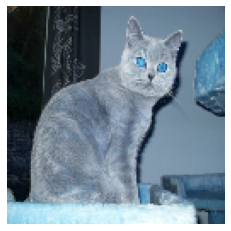

In [38]:
# Print sample image
img = np.array(img[0])
img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

plt.imshow(img)
plt.axis('off')
plt.show()

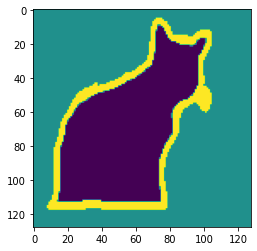

In [39]:
# Print sample mask
mask = (np.array(mask[0])/2) * 255.0
plt.imshow(mask)

## U-Net Model (Encoder: VGG16 - Decoder)

In [9]:
# VGG16
base_model = tf.keras.applications.VGG16(input_shape=img_shape, include_top=False)

In [10]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0     

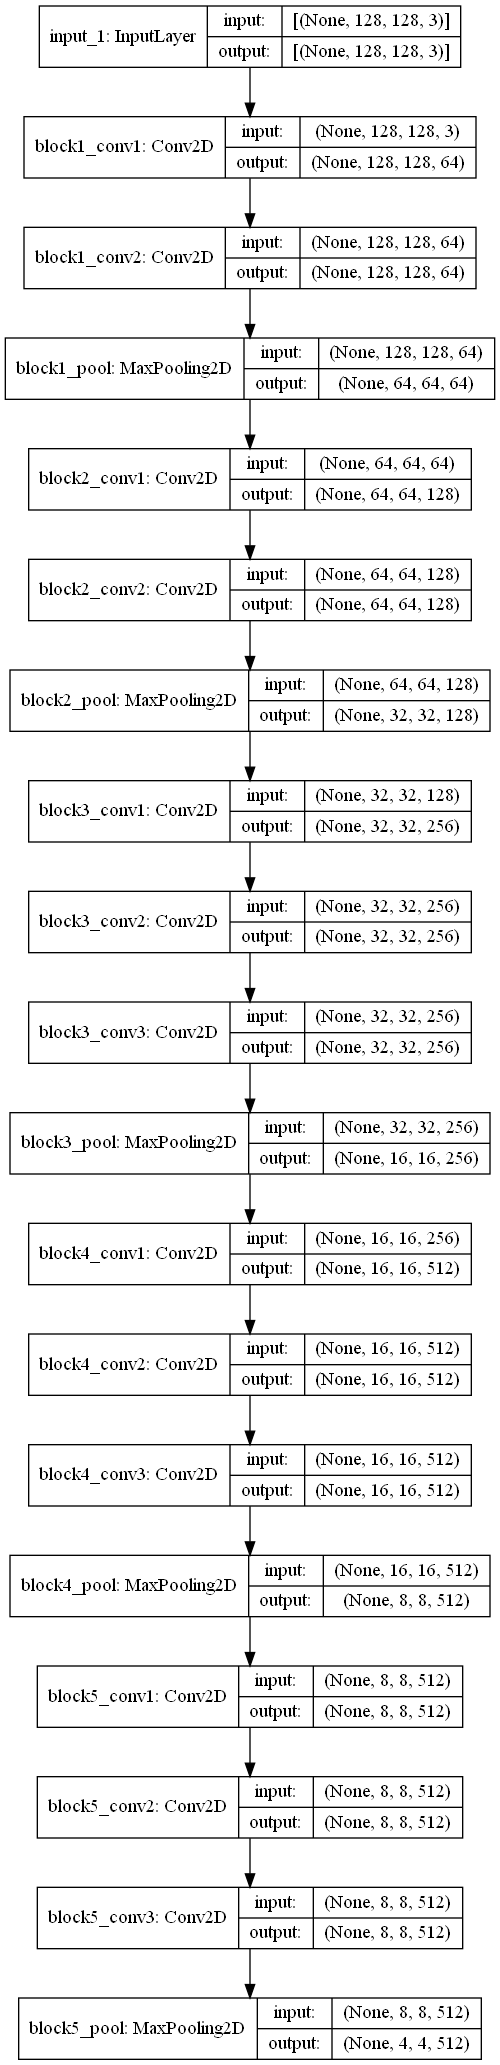

In [11]:
tf.keras.utils.plot_model(base_model, show_shapes=True)

In [12]:
# Selet middle layers's output tensors from VGG16

f_model = tf.keras.Model(inputs=[base_model.input], 
                         outputs=[base_model.get_layer(name='block5_conv3').output, 
                                  base_model.get_layer(name='block4_conv3').output, 
                                  base_model.get_layer(name='block3_conv3').output, 
                                  base_model.get_layer(name='block2_conv2').output, 
                                  base_model.get_layer(name='block1_conv2').output])

In [13]:
# fix parameters
f_model.trainable = False

In [14]:
# Modeling (U-Net structure)

i = tf.keras.Input(shape=img_shape)

out_8_8_512, out_16_16_512, out_32_32_256, out_64_64_128, out_128_128_64 = f_model(i)

out = tf.keras.layers.Conv2DTranspose(512,3,strides=2,padding='same')(out_8_8_512)
out = tf.keras.layers.Add()([out,out_16_16_512])

out = tf.keras.layers.Conv2DTranspose(256,3,strides=2,padding='same')(out)
out = tf.keras.layers.Add()([out,out_32_32_256])

out = tf.keras.layers.Conv2DTranspose(128,3,strides=2,padding='same')(out)
out = tf.keras.layers.Add()([out,out_64_64_128])

out = tf.keras.layers.Conv2DTranspose(64,3,strides=2,padding='same')(out)
out = tf.keras.layers.Add()([out,out_128_128_64])

out = tf.keras.layers.Conv2D(3, 3, activation='elu', padding='same') (out)
out = tf.keras.layers.Dense(3,activation='softmax')(out)

unet_model = tf.keras.Model(inputs=[i], outputs=[out])

In [15]:
unet_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
model (Functional)              [(None, 8, 8, 512),  14714688    input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_transpose (Conv2DTranspo (None, 16, 16, 512)  2359808     model[0][0]                      
__________________________________________________________________________________________________
add (Add)                       (None, 16, 16, 512)  0           conv2d_transpose[0][0]           
                                                                 model[0][1]                

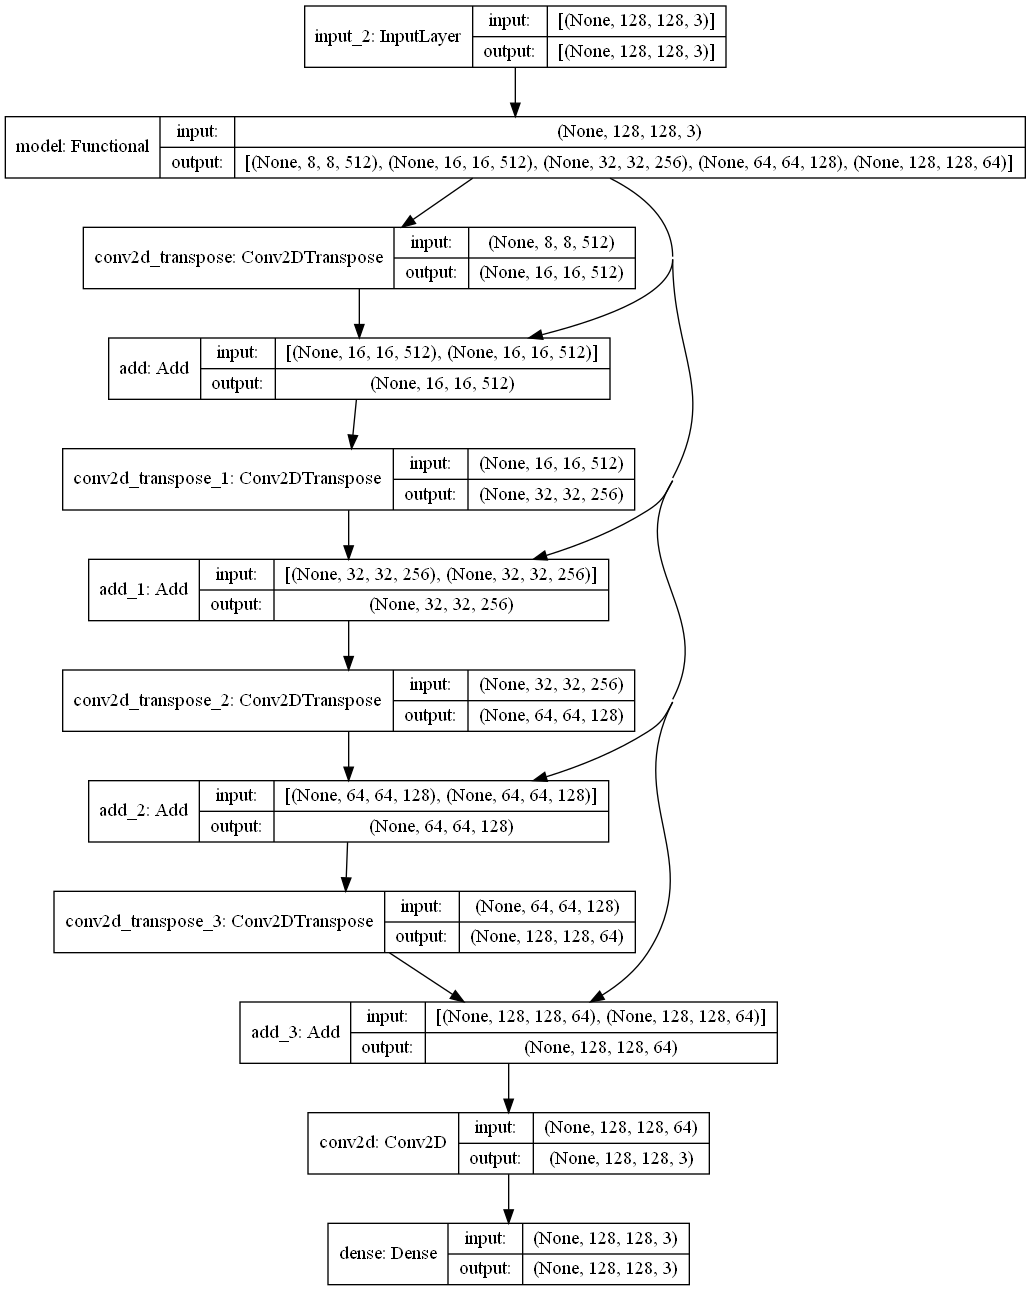

In [16]:
tf.keras.utils.plot_model(unet_model, show_shapes=True)

In [17]:
# Compile 
optimizer = tf.optimizers.Adam(learning_rate)
unet_model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['acc'])

# Fit
history = unet_model.fit(train_ds, batch_size=batch_size, epochs=epoch_num)

Epoch 1/10
230/230 [==============================] - 16s 49ms/step - loss: 1.0601 - acc: 0.4449
Epoch 2/10
230/230 [==============================] - 11s 48ms/step - loss: 0.9267 - acc: 0.6293
Epoch 3/10
230/230 [==============================] - 11s 48ms/step - loss: 0.8027 - acc: 0.7649 0s - loss: 0.8030 - acc: 0.76
Epoch 4/10
230/230 [==============================] - 11s 48ms/step - loss: 0.6943 - acc: 0.8250
Epoch 5/10
230/230 [==============================] - 11s 48ms/step - loss: 0.6246 - acc: 0.8388
Epoch 6/10
230/230 [==============================] - 11s 48ms/step - loss: 0.5814 - acc: 0.8457
Epoch 7/10
230/230 [==============================] - 11s 48ms/step - loss: 0.5511 - acc: 0.8495
Epoch 8/10
230/230 [==============================] - 11s 48ms/step - loss: 0.5259 - acc: 0.8520
Epoch 9/10
230/230 [==============================] - 11s 48ms/step - loss: 0.5043 - acc: 0.8551
Epoch 10/10
230/230 [==============================] - 12s 49ms/step - loss: 0.4866 - acc: 0.8569

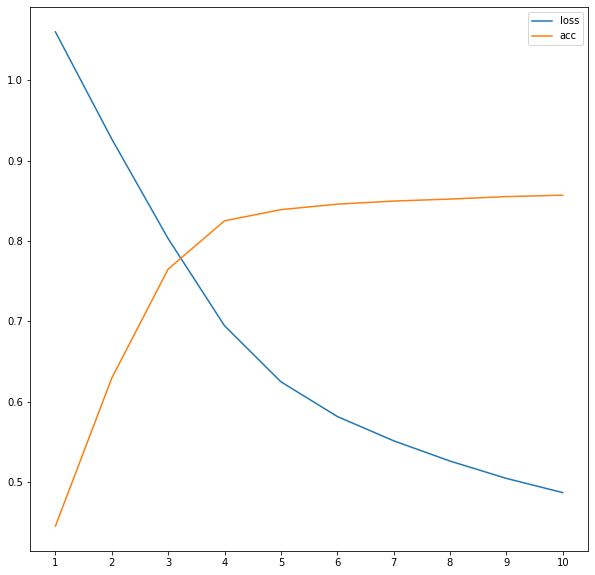

In [19]:
# Evaluate
plt.figure(figsize=(10, 10))
plt.plot(range(1, epoch_num+1), history.history['loss'], label='loss')
plt.plot(range(1, epoch_num+1), history.history['acc'], label='acc')
plt.xticks(range(1, epoch_num+1))
plt.legend()
plt.show()

In [57]:
# Sample batch
img, mask = next(iter(test_ds))

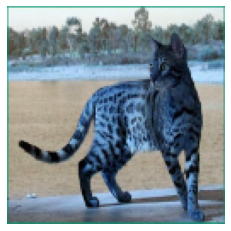

In [58]:
# Print 0th sample image
img_ = np.array(img[0])
img_ = cv2.cvtColor(img_, cv2.COLOR_RGB2BGR)

plt.imshow(img_)
plt.axis('off')
plt.show()

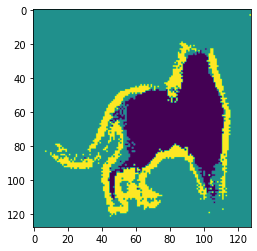

In [59]:
# Prediction
pred = unet_model.predict(img)

# Show 0th image's segmentation prediction 
pred_img = np.argmax(pred[0], -1)
plt.imshow(pred_img)

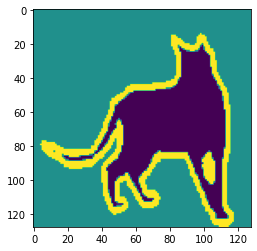

In [60]:
# Show true answer
plt.imshow(np.reshape(mask[0], (128, 128)))